#**Artist Identification:** Part Two

Conor Carmichael
---

In this notebook, I am going to try and improve on the previous task by using an the BERT Model from Google. BERT (Bidirectional Encoding Representations from Transformers) is a model that greatly improved upon similar previous work.

Here, I will use it on the same data set as before, in order to predict which artist wrote which verses. The training data is not enough to train a deep learning model from scratch, but BERT is a pretrained model, open for transfer learning. 


**References**
* [BERT Fine Tuning with PyTorch](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP#scrollTo=EKOTlwcmxmej), Chris McCormick and Nick Ryan. Heavily derived from this source, very great tutorial on transfer learning with BERT.


#1: Setup

##a) Imports, Installations

**Installations**



In [0]:
!pip install transformers
!pip install lyricsgenius
!pip install vaderSentiment


     |████████████████████████████████| 92kB 7.0MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
     |████████████████████████████████| 133kB 8.4MB/s 


**Imports**

In [0]:

#Lyrics
import lyricsgenius as lg

#General Imports
print("General imports...")
import time, os, re, itertools, copy, datetime
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
from tempfile import mkdtemp

from gensim.test.utils import get_tmpfile

#Metrics
print("Metrics imports...")
from sklearn.metrics import f1_score, accuracy_score, average_precision_score, recall_score, confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
%tensorflow_version 1.x
import tensorflow as tf
import torch
from transformers import BertTokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler


#SKLearn classifier 
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import spacy
import nltk

print('Done.')

General imports...
Metrics imports...
TensorFlow 1.x selected.


Using TensorFlow backend.


Done.


##b) GPU Setup

In [0]:
# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')
    

if torch.cuda.is_available():    

    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

Found GPU at: /device:GPU:0
There are 1 GPU(s) available.
We will use the GPU: Tesla P4


##c) Fetching Data

In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

file_path = '/content/drive/My Drive/Personal Projects/ArtistClassification'
file_name = 'lyrics_data.csv'
d2v_model = get_tmpfile("trained_d2v")

artists = ['The 1975', 'John Mayer', 'J. Cole', 'Kanye West', 'Modest Mouse', 'Red Hot Chili Peppers', "Taylor Swift"]
colors = ['grey',      'cyan',       'tan',     'orange',     'green',        'red',                   'magenta']


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


If downloading new artist information:

In [0]:
def retrieve_songs(artists, max_songs=100, sort='popularity', get_full_info=False):
    print("Retriving the top {} songs from artist, sorted by {}.\n".format(max_songs, sort))
    results = []
    for a in artists:
        start = time.time()
        artist = genius.search_artist(a, get_full_info=get_full_info, max_songs=max_songs, sort=sort)
        print('Finished {} in {:0.2}s.'.format(a, time.time()-start))
        results.append(artist)
    
    return results

def reformat(artists, split=None):
    collection = []
    for artist in artists:
        name = artist.name
    
        for song in artist.songs:
            df_template = {}

            df_template['name'] = name
            df_template['title'] = song.title
            df_template['album'] = song.album
            df_template['release_date'] = song.year
            df_template['lyrics'] = song.lyrics

            collection.append(df_template)  
    return collection

def save_df_to_drive(dataframe, fname, path):
    dataframe.to_csv(fname)
    !cp fname file_path

def add_artist(name, dataframe, max_songs=100, sort='popularity', get_full_info=False):
    # Adds artist to dataframe, copies to the drive, returns the new dataframe
    artist = genius.search_artist(name, get_full_info=get_full_info, max_songs=max_songs, sort=sort)
    df_add = artist_to_df(artist)
    res = dataframe.append(df_add)
    save_df_to_drive(res, os.path.join(file_path, file_name))
    return res

Try to fetch CSV, if fails download from genius.com


In [0]:
mask_client = len('client_access_token=')
genius_credentials = {}

#Important, takes a while to retrieve songs
MAX_SONGS = 100
FETCH_ON = 'popularity'

try: #Get data from google drive
    print('Reading data in from drive %s.' % (os.path.join(file_path, file_name)))
    raw_data = pd.read_csv(os.path.join(file_path, file_name) )
    print('Successfuly pulled data from Drive.')
except Exception as e:
    #If fails, open genius info file and get client access token, retrieve song info.
    print('File not found.')

    with open('/content/drive/My Drive/genius.txt', 'r') as r: #This will likely fail if you are not me. That is ok.
        lines = r.readlines()
        try:
            genius_credentials['client'] = lines[2][mask_client:]
            if genius_credentials['client']:
                genius = lg.Genius(genius_credentials['client'])
            r.close()
            
        except Exception as e:
            #If access token is not available, get token from user in order to retrieve song infor
            print(e)
            print('\nCredentials were not secured.\n')
            token = input('Input your client access token in order to continue: ')
            genius = lg.Genius(token)

        finally:
            #Live songs, remixes etc, just add redundancy. 
            genius.excluded_terms = ['(Remix)', '(Live)','Interlude', '(Demo)', '(Freestyle)']

            # Fetch songs, for the artists defined above
            results = retrieve_songs(artists, max_songs=MAX_SONGS, sort=FETCH_ON, get_full_info=False) 
            
            # Convert to appropriate format for task, then store as DataFrame
            results_processed = reformat(results)
            raw_data = pd.DataFrame(results_processed)

            #Create CSV, stores in Drive
            raw_data.to_csv(os.path.join(file_path, file_name))

Reading data in from drive /content/drive/My Drive/Personal Projects/ArtistClassification/lyrics_data.csv.
Successfuly pulled data from Drive.


##d) Preprocessing Data

**Difference from previous notebook*
*  'name' column -> 'class'
*  'lyrics' column -> 'verse'


In [0]:
verses_df = raw_data[['name','title','lyrics']]
verses_df = verses_df.rename(columns={'name': 'class'})
verses_df.head()

,class,title,lyrics
0,The 1975,Somebody Else,[Verse 1]\nSo I heard you found somebody else\...
1,The 1975,Love It If We Made It,"[Verse 1]\nWe're fucking in a car, shooting he..."
2,The 1975,Robbers,[Verse 1]\nShe had a face straight out a magaz...
3,The 1975,Sex,And this is how it starts\nYou take your shoes...
4,The 1975,Chocolate,[Verse 1]\nCall it a split cause you know that...


In [0]:
def split_lyrics(lyrics, split_token):
    # Split lyrics by verse/chorus. Will be predicting based off a stanza of a song.
    verses = re.split(split_token, lyrics) 
    # verses = [re.sub("\n", " ", v) for v in verses]

    return verses

def break_lyrics(dataframe, split_on):
    #\n\n is to split between verses, if splitting each line, need to remove artifacts
    new_collection = []
    for ind, row in dataframe.iterrows():
        splits = split_lyrics(row['lyrics'], split_on)

        for split in splits:
            df_template = {}
            df_template['class'] = row['class']
            df_template['title'] = row['title']
            df_template['verse'] = split

            new_collection.append(df_template)  
        
    return pd.DataFrame(new_collection)


In [0]:
verses_df = break_lyrics(verses_df, re.compile(r"\[.+?\]"))
verses_df = verses_df.sample(frac=1)

verses_df['verse'].replace('', np.nan, inplace=True)
verses_df.dropna(axis=0, inplace=True)

split = int(len(verses_df)*0.9)


verses_test_df = verses_df.iloc[split:] 
verses_df = verses_df.iloc[:split]

In [0]:
verses = verses_df['verse'].values
labels = verses_df['class'].values
titles = verses_df['title'].values

test_verses = verses_test_df['verse'].values
test_labels = verses_test_df['class'].values
test_titles = verses_test_df['title'].values

verses_test_df.head(n=10)

,class,title,verse
1286,J. Cole,Deja Vu,\nSometimes you worry 'bout the things he can ...
4389,Red Hot Chili Peppers,Right on Time,\nOne shot all I need\nI've got rhythm when I ...
2712,Kanye West,I Wonder,\nFind your dreams come true\nAnd I wonder if ...
512,John Mayer,New Light,\nI'm the boy in your other phone\nLighting up...
2919,Kanye West,Say You Will,\nMrs. So Fly crash-lands in my room\nCan't wa...
2134,Kanye West,Real Friends,"\nReal friends, how many of us?\nHow many of u..."
1968,J. Cole,Losing My Balance,\nI got a thing for this little mama\nShe do i...
891,John Mayer,Something Like Olivia,"\nWell, Olivia is taken\nBut a look like hers ..."
436,The 1975,Jesus Christ 2005 God Bless America,"\nFortunately I believe, lucky me\nI'm searchi..."
2541,Kanye West,Last Call,"\n\n""I ain't gonna front, it's kinda hot.""\n\n"


In [0]:
print('Test data: ',len(verses_test_df))
print('Train data: ',len(verses_df))

Test data:  474
Train data:  4266


##e) Reporting Functions

In [0]:
def generate_cm(true, pred, classes, normalize='false', title='', size=(14,12)):
    cm = confusion_matrix(true, pred, labels=classes, normalize=normalize)

    cm_df = pd.DataFrame(cm, index=classes, columns=classes)

    fig, ax = plt.subplots(nrows=1, ncols=1)
    fig.set_size_inches(size)
    ax.xaxis.tick_top()
    sn.heatmap(cm_df, annot=True, ax=ax)
    ax.set_title(title)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')

def classifier_report(true, predictions, id=None):
    true_binar = preprocessing.label_binarize(true, classes=pd.Series(true).unique())
    pred_binar = preprocessing.label_binarize(predictions, classes=pd.Series(true).unique())
    results = {
        'accuracy':round(accuracy_score(true, predictions), 3),
        'precision': round(average_precision_score(true_binar, pred_binar, average='macro'), 3),
        'recall':round(recall_score(true, predictions, average='macro'), 3),
        'f1': round(f1_score(true, predictions, average='macro'), 3)
    }
    if id:
        results['id'] = id,
    return results


#2: Tokenization

##a) BERT Tokenizer

In [0]:
print('Loading BERT tokenizer...')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

Loading BERT tokenizer...


In [0]:
# Testing the tokenizer:

# Print the original verse.
i = 727
print('Track: ', titles[i], ' by ', labels[i], ' \nOriginal: ', verses[i])

# Print the verse split into tokens.
print('Tokenized: ', tokenizer.tokenize(verses[i]))

# Print the verse mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(verses[i])))

Track:  Shake It Off  by  Taylor Swift  
Original:  
I stay out too late
Got nothing in my brain
That's what people say, mm, mm
That's what people say, mm, mm
I go on too many dates
But I can't make them stay
At least that's what people say, mm, mm
That's what people say, mm, mm


Tokenized:  ['I', 'stay', 'out', 'too', 'late', 'Got', 'nothing', 'in', 'my', 'brain', 'That', "'", 's', 'what', 'people', 'say', ',', 'mm', ',', 'mm', 'That', "'", 's', 'what', 'people', 'say', ',', 'mm', ',', 'mm', 'I', 'go', 'on', 'too', 'many', 'dates', 'But', 'I', 'can', "'", 't', 'make', 'them', 'stay', 'At', 'least', 'that', "'", 's', 'what', 'people', 'say', ',', 'mm', ',', 'mm', 'That', "'", 's', 'what', 'people', 'say', ',', 'mm', ',', 'mm']
Token IDs:  [146, 2215, 1149, 1315, 1523, 7348, 1720, 1107, 1139, 3575, 1337, 112, 188, 1184, 1234, 1474, 117, 2608, 117, 2608, 1337, 112, 188, 1184, 1234, 1474, 117, 2608, 117, 2608, 146, 1301, 1113, 1315, 1242, 4595, 1252, 146, 1169, 112, 189, 1294, 1172, 2215

##b) Verses to ids

In [0]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
max_tokens = 0
avg_tkns = 0
# For every verse...
for verse in verses:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    tkns = len(tokenizer.tokenize(verse))
    avg_tkns += tkns
    max_tokens = max(max_tokens, tkns)
    encoded_verse = tokenizer.encode(
                        verse,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_verse)
    
avg_tkns = avg_tkns/len(verses)
# Print sentence 0, now as a list of IDs.
print('Original: ', verses[0])
print('Token IDs:', input_ids[0])
print('Max tokens in verse: ', max_tokens)
print('Avg tokens in verse: ', avg_tkns)

Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (579 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (682 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (622 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (759 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Original:  
Can I go where you go?
Can we always be this close?
Forever and ever, ah
Take me out, and take me home (Forever and ever)
You're my, my, my, my
Oh, you're my, my, my, my
Darling, you're my, my, my, my lover
Token IDs: [101, 2825, 146, 1301, 1187, 1128, 1301, 136, 2825, 1195, 1579, 1129, 1142, 1601, 136, 11694, 1105, 1518, 117, 18257, 5055, 1143, 1149, 117, 1105, 1321, 1143, 1313, 113, 11694, 1105, 1518, 114, 1192, 112, 1231, 1139, 117, 1139, 117, 1139, 117, 1139, 2048, 117, 1128, 112, 1231, 1139, 117, 1139, 117, 1139, 117, 1139, 12777, 117, 1128, 112, 1231, 1139, 117, 1139, 117, 1139, 117, 1139, 7559, 102]
Max tokens in verse:  3383
Avg tokens in verse:  74.16385372714487


##c) Padding, Truncating

In [0]:
MAX_LEN = 128 # Adjusted from 64, to 128 because of average verse lenght being greater than 64

print('\nPadding/truncating all verses to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
# "post" indicates that we want to pad and truncate at the end of the sequence,
# as opposed to the beginning.
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", 
                          value=0, truncating="post", padding="post")

print('\nDone.')


Padding/truncating all verses to 128 values...

Padding token: "[PAD]", ID: 0

Done.


##d) Applying masks

In [0]:
# Create attention masks
attention_masks = []

# For each sentence...
for verse in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in verse]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

##e) Split data to Training, Test

In [0]:
# Use 90% for training and 10% for validation.
# This works since it is transfer learning, and data is limited

label_conversion = {
    'The 1975':0, 
    'John Mayer':1, 
    'J. Cole':2, 
    'Kanye West':3, 
    'Modest Mouse':4, 
    'Red Hot Chili Peppers':5, 
    "Taylor Swift":6
}

labels_binarized = [label_conversion[a] for a in labels]

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels_binarized, 
                                                            random_state=2020, test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels_binarized,
                                             random_state=2020, test_size=0.1)

In [0]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)

train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [0]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 16

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


#3: Sequence Classification with BERT

##a) Prep for training loop

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-cased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = len(artists), # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
epochs = 5

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

def class_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    scores = list()
    for i in range(len(artists)):
        args = np.argwhere(labels_flat==i)
        accuracy = np.sum(labels_flat[args] == pred_flat[args]) / len(args)
        scores.append(accuracy)
    return scores



In [0]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

##b) Training Loop


In [0]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Store the average loss after each epoch so we can plot them.
loss_values = []
# Store class accuracies, then avg columns.
class_accuracies = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        class_accuracies.append( class_accuracy(logits, label_ids) )

        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    240.    Elapsed: 0:00:17.
  Batch    80  of    240.    Elapsed: 0:00:35.
  Batch   120  of    240.    Elapsed: 0:00:52.
  Batch   160  of    240.    Elapsed: 0:01:09.
  Batch   200  of    240.    Elapsed: 0:01:27.

  Average training loss: 1.65
  Training epcoh took: 0:01:45

Running Validation...


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == '':


  Accuracy: 0.53
  Validation took: 0:00:03

======== Epoch 2 / 5 ========
Training...
  Batch    40  of    240.    Elapsed: 0:00:18.
  Batch    80  of    240.    Elapsed: 0:00:35.
  Batch   120  of    240.    Elapsed: 0:00:53.
  Batch   160  of    240.    Elapsed: 0:01:11.
  Batch   200  of    240.    Elapsed: 0:01:28.

  Average training loss: 0.97
  Training epcoh took: 0:01:46

Running Validation...
  Accuracy: 0.75
  Validation took: 0:00:03

======== Epoch 3 / 5 ========
Training...
  Batch    40  of    240.    Elapsed: 0:00:18.
  Batch    80  of    240.    Elapsed: 0:00:35.
  Batch   120  of    240.    Elapsed: 0:00:53.
  Batch   160  of    240.    Elapsed: 0:01:11.
  Batch   200  of    240.    Elapsed: 0:01:29.

  Average training loss: 0.51
  Training epcoh took: 0:01:47

Running Validation...
  Accuracy: 0.81
  Validation took: 0:00:03

======== Epoch 4 / 5 ========
Training...
  Batch    40  of    240.    Elapsed: 0:00:18.
  Batch    80  of    240.    Elapsed: 0:00:36.
  Bat

In [0]:
class_accuracies = np.asarray(class_accuracies)
print('Class Avg Accuracies on Validation Data\n')
pd.DataFrame(class_accuracies, columns=artists).mean()

Class Avg Accuracies on Validation Data



The 1975                 0.700000
John Mayer               0.654545
J. Cole                  0.628889
Kanye West               0.697917
Modest Mouse             0.770606
Red Hot Chili Peppers    0.729333
Taylor Swift             0.933205
dtype: float64

##c) Graphing Loss

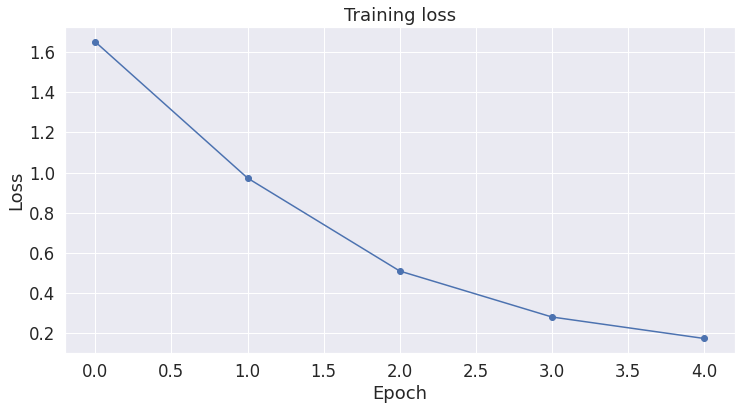

In [0]:
# Use plot styling from seaborn.
sn.set(style='darkgrid')

# Increase the plot size and font size.
sn.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

##d) Evaluating the model on test data

In [0]:
# Report the number of sentences.
print('Number of test verses: {:,}\n'.format(verses_test_df.shape[0]))

# # # Create sentence and label lists
# reviews_test = reviews_test_df['reviewText'].values
# labels_test = reviews_test_df['label'].values

test_inputs =  verses_test_df['verse'].values
labels_test = verses_test_df['class'].values
labels_test = [label_conversion[a] for a in labels_test]

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for verse in test_inputs:
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    encoded_sent = tokenizer.encode(
                        verse,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                   )
    
    input_ids.append(encoded_sent)

# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, 
                          dtype="long", truncating="post", padding="post")

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Convert to tensors.
prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels_test)

# Set the batch size.  
batch_size = 16  

# Create the DataLoader.
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Token indices sequence length is longer than the specified maximum sequence length for this model (645 > 512). Running this sequence through the model will result in indexing errors


Number of test verses: 474



In [0]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(prediction_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 474 test sentences...
    DONE.


In [0]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [0]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in true_labels for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

MCC: 0.663


{'accuracy': 0.711, 'f1': 0.713, 'precision': 0.557, 'recall': 0.705}

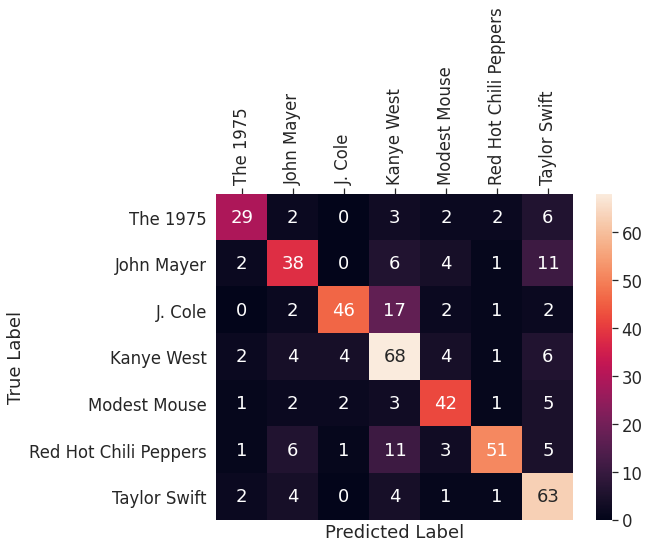

In [0]:
reversed_labels = [artists[label] for label in flat_true_labels]
reversed_predictions = [artists[label] for label in flat_predictions]
results = classifier_report(reversed_labels, reversed_predictions)
generate_cm(reversed_labels, reversed_predictions, artists, normalize=None, size=(8,6))
# generate_cm(reversed_labels, reversed_predictions, artists, normalize='true', size=(8,6))

print('MCC: %.3f' % mcc)
results

##e) Analysis

This model is simpler to develop in that there are less choices to make. Using 6 epochs may have been slightly too much, but it made for better performance than 4. This model works better than the SVC classifier on Taylor Swift and John Mayer lyrics. 

BERT Results
MCC: 0.714

{'accuracy': 0.753, 'f1': 0.75, 'precision': 0.607, 'recall': 0.747}

#4: Preparing SVC Classifier

Need to prepare pipeline, get class accuracy results on validation data.

I am going to take the best features from the other project, put them into the pipeline, and train. 

Features to be included:

*   TF-IDF Vectorizer
*   Doc 2 Vec
*   Compound Sentiment Analysis
*   Line Count
*   Word Count


N.B: The lyrics are in 
```train_inputs, validation_inputs, test_inputs```
, and the labels are in respectively named arrays. I will take these, and change them into dataframes while calculating features to maintain the pipeline structure from the previous project.




In [0]:
verses_test_df['class'].value_counts()
# verses_df.info()

Kanye West               89
Red Hot Chili Peppers    78
Taylor Swift             75
J. Cole                  70
John Mayer               62
Modest Mouse             56
The 1975                 44
Name: class, dtype: int64

##a) Doc2Vec

In [0]:
# Referenced https://fzr72725.github.io/2018/01/14/genism-guide.html
def tag_docs(df):
    tagged = df.apply(lambda row: 
                            TaggedDocument(words=tokenize_normalize(row['verse']),
                                            tags=[row['class']]), axis=1
                            )
    return tagged

def train_w2v(tagged):
    sentences = tagged.values
    model = Doc2Vec(sentences, alpha=0.025, min_alpha=0.001, min_count=5, window=8, epochs=10)
    return model

def feature_doc2vec(d2v, tagged_docs):
    sentences =  tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], d2v.infer_vector(doc.words, steps=20)) for doc in sentences])
    return targets, regressors



##b) Sentiment Analysis, Line Counts, Word Counts

In [0]:
vader = SentimentIntensityAnalyzer()
reset_keys = ['class','title','verse']

verses_df = verses_df[reset_keys]
verses_test_df = verses_test_df[reset_keys]

verses_df = pd.concat([verses_df,  verses_df['verse'].apply(lambda l: pd.Series({'compound': vader.polarity_scores(l)['compound']}))  ], axis=1)

verses_df = pd.concat([verses_df, verses_df['verse'].apply(lambda l: pd.Series({
                        'word_count': len(re.split('\s+', l)),
                            'line_count': len(re.split('\n+', l)),
                        })) ], 
                        axis=1) 

verses_test_df = pd.concat([verses_test_df,  verses_test_df['verse'].apply(lambda l: pd.Series({'compound': vader.polarity_scores(l)['compound']}))  ], axis=1)

verses_test_df = pd.concat([verses_test_df, verses_test_df['verse'].apply(lambda l: pd.Series({
                        'word_count': len(re.split('\s+', l)),
                            'line_count': len(re.split('\n+', l)),
                        })) ], 
                        axis=1) 
     

##c) Tokenize, Normalize

In [0]:
nlp = spacy.load('en_core_web_sm', disable=['ner'])
nlp.remove_pipe('tagger')
nlp.remove_pipe('parser')
nltk.download('stopwords')
sw_set = set(nltk.corpus.stopwords.words('english'))

#Prevents errors when passing pre tokenized data to a vectorizer
def dum_tokenizer(docs):
    return docs
def dum_preprocessor(docs):
    return docs


def spacy_tokenize(string):
    tokens = []
    doc = nlp(string)
    for token in doc:
        tokens.append(token)
    return tokens


def normalize(tokens ):
    normalized_tokens = list()
    for token in tokens:
        normalized = token.text.lower().strip()
        if ((token.is_alpha or token.is_digit)):
            normalized_tokens.append(normalized)
    return normalized_tokens


def tokenize_normalize(string):
    return normalize(spacy_tokenize(string))  


# Specifically tokenizes for punctuation.
def punctuation_tn(string):
    tkns = spacy_tokenize(string)
    normalized_tokens = list()
    for token in tkns:
        normalized = token.text.lower().strip()
        if token.text in [',','!','?']:
            normalized_tokens.append(normalized)

    return normalized_tokens


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


##d) Feature Extraction Class

In [0]:
numerical_feature_keys = ['compound', 'word_count', 'line_count', 'avg_line_len', 'avg_word_len']

class FeatureSelect(BaseEstimator, TransformerMixin):

    def __init__(self, key=None):
        self.key=key

    def fit(self, x, y=None):
        return self

    def transform(self, data):

        if self.key: 
            if self.key in numerical_feature_keys:
                return np.reshape(data[self.key].to_numpy(), (-1, 1))
                
            elif self.key == 'pos':
                return pos_tagger(data)

            elif self.key=='doc2vec':  
                tagged = tag_docs(data)
                try:
                    #Load D2V model
                    print('Loading Doc2Vec Model..')
                    model = Doc2Vec.load(d2v_model) 
                    print("Loaded.")
                except Exception as e:
                    #Not found, 
                    print(e,"\nRetraining Doc 2 Vec Model")
                    model = train_w2v(tagged)

                    print("Retrained.")
                    model.save(d2v_model)
                    print("Model saved.")

                finally:
                    _, features = feature_doc2vec(model, tagged)
                    # print(features)
                    # print(np.ndim(features))
                    # print(feature.shape)

                    # features = np.mean(np.asarray(features), axis=1)
                    # features = np.reshape(features,(-1,1))
                    return np.asarray(features)
            else:
                return data[self.key]



##e) Pipeline

In [0]:

feature_union = FeatureUnion(
            transformer_list=[
                              
                ### Selected as best by iterative method beneath.
                ('tfidf vectorizer', Pipeline([
                    ('selector', FeatureSelect(key='verse')),
                    ('tfidf', TfidfVectorizer(tokenizer=tokenize_normalize, ngram_range=(1,2), sublinear_tf=True))
                ])),
                ('d2v', Pipeline([
                    ('d2v', FeatureSelect(key='doc2vec'))
                ])),

                ### Selected by SelectKBest
                ('compound', Pipeline([
                    ('selector', FeatureSelect(key='compound')),
                ])),

                ('line_count', Pipeline([
                    ('selector', FeatureSelect(key='line_count')), 
                    ('value', StandardScaler() )
                ])),
                ('word_count', Pipeline([ #Bad Feature
                    ('selector', FeatureSelect(key='word_count')), 
                    ('value', StandardScaler() )
                ])),

        ])

svc_pipeline = Pipeline([
        ('union', feature_union),
        ('svc', SVC(kernel='linear', C=1, probability=True))
    ])

##f) Training SVC

In [0]:
svc_pipeline.fit(verses_df, labels_binarized)

Loading Doc2Vec Model..
Loaded.


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Pipeline(memory=None,
         steps=[('union',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('tfidf vectorizer',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelect(key='verse')),
                                                                 ('tfidf',
                                                                  TfidfVectorizer(analyzer='word',
                                                                                  binary=False,
                                                                                  decode_error='strict',
                                                                                  dtype=<class 'numpy.float64'>,
                                                                                  encoding='utf-8',
        

#5: Combining Models

To combine the models, I can apply a softmax function to the BERT logit outputs, to obtain probabilities per class for a sample. The sklearn svc allows for me to use `predict_proba()` to get these values. Then, I can add the up the probabilities per class, to see which class is most likely based off the two models.

##a) BERT Predictions

In [0]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0) 

def combine_predict(bert_prob, svc_prob, i):
    b_as = np.argsort(bert_prob)[::-1] 
    s_as = np.argsort(svc_prob)[::-1]
    combined = np.sum([bert_prob, svc_prob], axis=0)
    combined = np.argsort(combined)[::-1][0]
    if b_as[0] != s_as[0] :
        print('\nDisagreement at ',i,'\nBERT: ', b_as[0] , ' , ', bert_prob[b_as[0]], '% conf')
        print('SVC: ', s_as[0] , ' , ', bert_prob[s_as[0]], '% conf')
        print(combined)

    return combined


In [0]:
bert_predictions = np.array([item for sublist in predictions for item in sublist])
flat_true_labels = [item for sublist in true_labels for item in sublist]

print('Labels are same for bert test, svc test: ', flat_true_labels == svc_true_class_digit)
bert_probabilities = [softmax(p) for p in bert_predictions]

"\nSometimes you worry 'bout the things he can provide for ya\nWhenever you around I seem to come alive for ya\nI finally recognize the feelings that's inside for ya\nAlthough I know your man and trust me he would die for ya\nThese quiet thoughts of you been going on for years now\nI saw you in the party, soft lips, soft spoken\nI came and talked to you but homie interfered now\nHe introduced you as his girl and I was heartbroken\nSome people talk about that love at first sight shit\nTo keep it real I don't know whether I believe it's true\nBut if it is then tell me if I'm wrong or right\nIf I fell in love with you before I ever even knew\nI catch your eye then look away as if it never happened\nAt times I feel as though I'm caught up in a strange dream\nIf eyes could talk then mines would tell ya that I'm feeling you\nSometimes I swear your eyes be telling me the same thing\n\n"

##b) SVC Predictions

In [0]:
svc_probabilities = svc_pipeline.predict_proba(verses_test_df)
# svc_predictions = svc_pipeline.predict(verses_test_df)


Loading Doc2Vec Model..
Loaded.


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:410: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


[0.00323267 0.00051003 0.9810253  0.0103203  0.00079047 0.00247226
 0.00164893]
[0.00076195 0.00000016 0.997396   0.00002974 0.00000013 0.00000204
 0.00180998]


'J. Cole'

##c) Combining

In [0]:
combined_binar = [combine_predict(bert_probabilities[i], svc_probabilities[i], i) for i in range(len(bert_probabilities)) ]

combined_prediction = [artists[digit] for digit in combined_binar]

print(classifier_report(test_labels, combined_prediction))
# generate_cm(test_labels, combined_prediction, artists, normalize=None, title='Combining BERT and SVC Predictions', size=(10,8))


Disagreement at  2 
BERT:  1  ,  0.80177903 % conf
SVC:  3  ,  0.033263847 % conf
1

Disagreement at  3 
BERT:  6  ,  0.8652535 % conf
SVC:  1  ,  0.11076007 % conf
6

Disagreement at  4 
BERT:  4  ,  0.49162003 % conf
SVC:  1  ,  0.32210204 % conf
1

Disagreement at  10 
BERT:  6  ,  0.98317724 % conf
SVC:  1  ,  0.009407278 % conf
6

Disagreement at  11 
BERT:  3  ,  0.50836074 % conf
SVC:  2  ,  0.47341344 % conf
2

Disagreement at  13 
BERT:  3  ,  0.9618257 % conf
SVC:  6  ,  0.005140988 % conf
3

Disagreement at  14 
BERT:  4  ,  0.9298412 % conf
SVC:  5  ,  0.0038741576 % conf
4

Disagreement at  16 
BERT:  1  ,  0.96188504 % conf
SVC:  5  ,  0.00988557 % conf
1

Disagreement at  17 
BERT:  2  ,  0.97109824 % conf
SVC:  3  ,  0.023448339 % conf
3

Disagreement at  21 
BERT:  3  ,  0.7469859 % conf
SVC:  2  ,  0.007966602 % conf
3

Disagreement at  25 
BERT:  0  ,  0.7068273 % conf
SVC:  2  ,  0.030030921 % conf
0

Disagreement at  26 
BERT:  3  ,  0.5994635 % conf
SVC:  5  ,  0

In [0]:
i=352 
print(combined_prediction[i])
test_labels[i]


Taylor Swift


'Taylor Swift'